# Etheteum price prediction model

This project aims to predict the next-day price of Etheureum crypocurrency.

We will:

Start by using and understanding the model which Jose Pereira developed for Bitcoin, you can find it here https://github.com/pereirajose3/bitcoin_price_prediction_ensemble_bilstm-gru_savitzky_golay_filter/blob/main/ensemble_bilstm_gru_savitzky_golay_filter.ipynb. 

Once we understand the model, we will fine tune to Ethereum

If time allows, I would like to:

- Understand which variables help price prediction
- Predict at 1,2,3,4,5,6 months
- Tried and test other AI models

# 1. Import libraries

In [1]:
import os # Standart Library for programming, it lets me interact with several fuctions that come handy in day to day programming
import datetime # imports all the content from datatime module, which supplies classes to work with data and time

import IPython  # is a command sheel for interactive computing in multiple programing languages, which offers introspection, rich media, shell syntax, tab completion and history.
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras 
from tensorflow.keras import layers

# For PLotting we will use these library

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
#!pip install pydot
#pip install yfinance
#pip install yahoo_fin
#pip install requests_html

import yfinance as yf


In [4]:
from yahoo_fin.stock_info import get_data # import historical price data
import yahoo_fin.stock_info as si #Here we are just importing the whole stock_info module as si, so we can easily call all the methods without a new import each time.

2. Import Data

2.1 Download data from Yahoo:Finance API 

API is a set of defined rules that explain how computers or applications communicate with one another. It sits between an application and the web server,acting as an intermidiary layer that processes data transfer between systems.


In [5]:
# define start and end date of our data
start_date, end_date = '2017-11-09', '2023-02-01'

#Bitcoin USD
msft = yf.Ticker("BTC-USD")
# get historical market data
btc_usd = msft.history(interval='1d', start=start_date, end=end_date)
btc_usd.index = btc_usd.index.tz_localize(None)

#Ethereum USD (ETH-USD)
msft = yf.Ticker("ETH-USD")
# get historical market data
eth_usd = msft.history(interval='1d', start=start_date, end=end_date)
eth_usd.index = eth_usd.index.tz_localize(None)

#Nasdaq USD
msft = yf.Ticker("NDAQ")
# msft historical market data
nasdaq = msft.history(interval='1d', start=start_date, end=end_date)
nasdaq.index = nasdaq.index.tz_localize(None)


#Gold Prices
msft = yf.Ticker("GC=F")
# get historical market data
gold = msft.history(interval='1d', start=start_date, end=end_date)
gold.index = gold.index.tz_localize(None)

#Crude Oil
msft = yf.Ticker("CL=F")
# get historical market data
oil = msft.history(interval='1d', start=start_date, end=end_date)
oil.index = oil.index.tz_localize(None)

#SP500
msft = yf.Ticker("^GSPC")
# get historical market data
sp500 = msft.history(interval='1d', start=start_date, end=end_date)
sp500.index = sp500.index.tz_localize(None)

#VIX-Traders and investors use VIX as a measure of market sentiment and risk.
msft = yf.Ticker("^VIX")
# get historical market data
vix = msft.history(interval='1d', start=start_date, end=end_date)
vix.index = vix.index.tz_localize(None)

#ftse100
msft = yf.Ticker("^FTSE")
# get historical market data
ftse100 = msft.history(interval='1d', start=start_date, end=end_date)
ftse100.index = ftse100.index.tz_localize(None)

#TNX-is the ticker symbol for the 10-year Treasury note yield
msft = yf.Ticker("^TNX")
# get historical market data
tnx = msft.history(interval='1d', start=start_date, end=end_date)
tnx.index = tnx.index.tz_localize(None)

#CMC200: top  200 comapanies listed in Australia
msft = yf.Ticker("^CMC200")
# get historical market data
cmc200 = msft.history(interval='1d', start=start_date, end=end_date)
cmc200.index = cmc200.index.tz_localize(None)

#GBP/USD
msft = yf.Ticker("GBPUSD=X")
# get historical market data
gbp_usd = msft.history(interval='1d', start=start_date, end=end_date)
gbp_usd.index = gbp_usd.index.tz_localize(None)

#EUR/USD
msft = yf.Ticker("EURUSD=X")
# get historical market data
eur_usd = msft.history(interval='1d', start=start_date, end=end_date)
eur_usd.index = eur_usd.index.tz_localize(None)

#USD/JPY
msft = yf.Ticker("JPY=X")
# get historical market data
usd_jpy = msft.history(interval='1d', start=start_date, end=end_date)
usd_jpy.index = usd_jpy.index.tz_localize(None)


Import CPI data series from the BLS web service

In [6]:
import requests
import json

NOTE: You have to create an account with BLS nd insert your unique API


In [7]:
bls_api_key = 'INSERT YOUR API HERE'

In [8]:
def fetch_cpi_data(data_series_id, start_year, end_year):
    try:
        bls_data_api_url = 'INSERT YOU API url KEY HERE'
        headers = {'Content-type': 'application/json'}
        data = json.dumps({"registrationkey": bls_api_key, "seriesid": [data_series_id], "startyear": start_year, "endyear": end_year})
        response = requests.post(bls_data_api_url, data=data, headers=headers)
        if response.status_code != 200:
            raise Exception(f"Error retrieving data: {response.text}")
        #  Parse JSON
        json_data = json.loads(response.text)
        if json_data['status'] != 'REQUEST_SUCCEEDED':
            raise Exception(f"Error retrieving data: {response.text}")
        results_df = pd.DataFrame()
        for series in json_data['Results']['series']:
            series_id = series['seriesID']
            for item in series['data']:
                year = int(item['year'])
                period = item['period']
                value = float(item['value'])
                year_mon = f"{year}-{int(period.replace('M',''))}"
                date = datetime.datetime.strptime(year_mon, "%Y-%m")
                row_df = pd.DataFrame({'date': [date], 'year': [year], 'period': [period], 'value': [value]})
                results_df = pd.concat([results_df, row_df], ignore_index=True)
        #  Sort ascending
        results_df = results_df.sort_values(by=['date'], ascending=True)
        results_df.set_index(['date'], inplace=True)
        return results_df
    except Exception as ex:
        print(f"Failed to fetch data: {ex}")

In [9]:
#  Set date range
today = datetime.date.today()
end_year_str = str(today.year)
days_delta = datetime.timedelta(5 * 365)
start_date = today - days_delta
start_year_str = str(start_date.year)
    
#  Fetch CPI
data_series_id = 'CUUR0000SA0'
cpi_data_df = fetch_cpi_data(data_series_id, start_year_str, end_year_str)
cpi_data_df.to_csv('cpi_data_df.csv')


In [10]:
# Calculate inflation rate
cpi_data_df['inflation_rate'] = cpi_data_df['value'].pct_change()*100
cpi_data_df['cpi_value'] = cpi_data_df['value']
# Display dataframe
print(cpi_data_df)

            year period    value  inflation_rate  cpi_value
date                                                       
2018-01-01  2018    M01  247.867             NaN    247.867
2018-02-01  2018    M02  248.991        0.453469    248.991
2018-03-01  2018    M03  249.554        0.226113    249.554
2018-04-01  2018    M04  250.546        0.397509    250.546
2018-05-01  2018    M05  251.588        0.415892    251.588
...          ...    ...      ...             ...        ...
2022-10-01  2022    M10  298.012        0.405649    298.012
2022-11-01  2022    M11  297.711       -0.101003    297.711
2022-12-01  2022    M12  296.797       -0.307009    296.797
2023-01-01  2023    M01  299.170        0.799536    299.170
2023-02-01  2023    M02  300.840        0.558211    300.840

[62 rows x 5 columns]


Create a data frame of all the data

In [11]:
#Create a dataframe with closing prices
btc_usd["BTC-USD"]=btc_usd['Close']
eth_usd['eth_usd']=eth_usd['Close']
nasdaq['nasdaq']=nasdaq['Close']
gold['gold']=gold['Close']
oil['oil']=oil['Close']
sp500['sp500']=sp500['Close']
vix['vix']=vix['Close']
ftse100['ftse100']=ftse100['Close']
tnx['tnx']=tnx['Close']
cmc200['cmc200']=cmc200['Close']
gbp_usd['gbp_usd']=gbp_usd['Close']
eur_usd['eur_usd']=eur_usd['Close']
usd_jpy['usd_jpy']=usd_jpy['Close']
cpi_data_df['cpi_Data_df']=cpi_data_df['cpi_value']

df=pd.concat([eth_usd['Open'], eth_usd['High'], eth_usd['Low'], eth_usd['Close'], eth_usd['Volume'],btc_usd["BTC-USD"],nasdaq['nasdaq'], gold['gold'],oil['oil'],sp500['sp500'],vix['vix'],ftse100['ftse100'],tnx['tnx'],gbp_usd['gbp_usd'],eur_usd['eur_usd'],usd_jpy['usd_jpy'],cpi_data_df['cpi_value']], axis=1, join="outer")

In [12]:
eth_usd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1910 entries, 2017-11-09 to 2023-01-31
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1910 non-null   float64
 1   High          1910 non-null   float64
 2   Low           1910 non-null   float64
 3   Close         1910 non-null   float64
 4   Volume        1910 non-null   int64  
 5   Dividends     1910 non-null   float64
 6   Stock Splits  1910 non-null   float64
 7   eth_usd       1910 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 198.8 KB


In [13]:
df.count()

Open         1910
High         1910
Low          1910
Close        1910
Volume       1910
BTC-USD      1910
nasdaq       1314
gold         1315
oil          1317
sp500        1314
vix          1314
ftse100      1318
tnx          1314
gbp_usd      1362
eur_usd      1362
usd_jpy      1362
cpi_value      62
dtype: int64

In [14]:
df

,Open,High,Low,Close,Volume,BTC-USD,nasdaq,gold,oil,sp500,vix,ftse100,tnx,gbp_usd,eur_usd,usd_jpy,cpi_value
2017-11-09,308.644989,329.451996,307.056000,320.884003,8.932500e+08,7143.580078,22.485592,1285.599976,57.169998,2584.620117,10.500000,7484.100098,2.331,1.311303,1.159689,113.927002,NaN
2017-11-10,320.670990,324.717987,294.541992,299.252991,8.859860e+08,6618.140137,22.436792,1272.400024,56.740002,2582.300049,11.290000,7433.000000,2.400,1.314440,1.164687,113.375000,NaN
2017-11-11,298.585999,319.453003,298.191986,314.681000,8.423010e+08,6357.600098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-12,314.690002,319.153015,298.513000,307.907990,1.613480e+09,5950.069824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-13,307.024994,328.415009,307.024994,316.716003,1.041890e+09,6559.490234,22.997940,1277.300049,56.759998,2584.840088,11.500000,7415.200195,2.400,1.312026,1.166113,113.685997,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-28,1598.125366,1604.704102,1565.390137,1572.435059,5.803653e+09,23031.089844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-29,1572.629517,1653.724976,1568.984863,1646.155640,8.801292e+09,23774.566406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-30,1646.147705,1646.651611,1546.660767,1567.326538,9.180418e+09,22840.138672,59.420177,1922.900024,77.900002,4017.770020,19.940001,7784.899902,3.551,1.240030,1.087146,129.854004,NaN
2023-01-31,1567.419922,1598.517578,1563.804321,1586.535400,6.585191e+09,23139.283203,59.958096,1929.500000,78.870003,4076.600098,19.400000,7771.700195,3.529,1.235361,1.085069,130.479004,NaN


Fill the weekeds on stock price with friday price 

In [15]:
#Fill weekends na stock price with friday price
df.fillna(method='ffill', inplace=True)
df=df[1:]

In [16]:
#Fill the rest of null of cpi with median 
df['cpi_value'] = df['cpi_value'].fillna(df['cpi_value'].median())

In [17]:
df

,Open,High,Low,Close,Volume,BTC-USD,nasdaq,gold,oil,sp500,vix,ftse100,tnx,gbp_usd,eur_usd,usd_jpy,cpi_value
2017-11-10,320.670990,324.717987,294.541992,299.252991,8.859860e+08,6618.140137,22.436792,1272.400024,56.740002,2582.300049,11.290000,7433.000000,2.400,1.314440,1.164687,113.375000,259.101
2017-11-11,298.585999,319.453003,298.191986,314.681000,8.423010e+08,6357.600098,22.436792,1272.400024,56.740002,2582.300049,11.290000,7433.000000,2.400,1.314440,1.164687,113.375000,259.101
2017-11-12,314.690002,319.153015,298.513000,307.907990,1.613480e+09,5950.069824,22.436792,1272.400024,56.740002,2582.300049,11.290000,7433.000000,2.400,1.314440,1.164687,113.375000,259.101
2017-11-13,307.024994,328.415009,307.024994,316.716003,1.041890e+09,6559.490234,22.997940,1277.300049,56.759998,2584.840088,11.500000,7415.200195,2.400,1.312026,1.166113,113.685997,259.101
2017-11-14,316.763000,340.177002,316.763000,337.631012,1.069680e+09,6635.750000,23.168726,1281.500000,55.700001,2578.870117,11.590000,7414.399902,2.381,1.312336,1.166494,113.584999,259.101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-28,1598.125366,1604.704102,1565.390137,1572.435059,5.803653e+09,23031.089844,60.266903,1928.599976,79.680000,4070.560059,18.510000,7765.200195,3.518,1.241527,1.089443,129.800003,299.170
2023-01-29,1572.629517,1653.724976,1568.984863,1646.155640,8.801292e+09,23774.566406,60.266903,1928.599976,79.680000,4070.560059,18.510000,7765.200195,3.518,1.241527,1.089443,129.800003,299.170
2023-01-30,1646.147705,1646.651611,1546.660767,1567.326538,9.180418e+09,22840.138672,59.420177,1922.900024,77.900002,4017.770020,19.940001,7784.899902,3.551,1.240030,1.087146,129.854004,299.170
2023-01-31,1567.419922,1598.517578,1563.804321,1586.535400,6.585191e+09,23139.283203,59.958096,1929.500000,78.870003,4076.600098,19.400000,7771.700195,3.529,1.235361,1.085069,130.479004,299.170


In [18]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Volume       0
BTC-USD      0
nasdaq       0
gold         0
oil          0
sp500        0
vix          0
ftse100      0
tnx          0
gbp_usd      0
eur_usd      0
usd_jpy      0
cpi_value    0
dtype: int64

In [19]:
print('Total number of days present in the dataset: ',df.shape[0])
print('Total number of fields present in the dataset: ',df.shape[1])

Total number of days present in the dataset:  1910
Total number of fields present in the dataset:  17


In [20]:
df.shape

(1910, 17)

In [21]:
df.head()

,Open,High,Low,Close,Volume,BTC-USD,nasdaq,gold,oil,sp500,vix,ftse100,tnx,gbp_usd,eur_usd,usd_jpy,cpi_value
2017-11-10,320.670990,324.717987,294.541992,299.252991,8.859860e+08,6618.140137,22.436792,1272.400024,56.740002,2582.300049,11.29,7433.000000,2.400,1.314440,1.164687,113.375000,259.101
2017-11-11,298.585999,319.453003,298.191986,314.681000,8.423010e+08,6357.600098,22.436792,1272.400024,56.740002,2582.300049,11.29,7433.000000,2.400,1.314440,1.164687,113.375000,259.101
2017-11-12,314.690002,319.153015,298.513000,307.907990,1.613480e+09,5950.069824,22.436792,1272.400024,56.740002,2582.300049,11.29,7433.000000,2.400,1.314440,1.164687,113.375000,259.101
2017-11-13,307.024994,328.415009,307.024994,316.716003,1.041890e+09,6559.490234,22.997940,1277.300049,56.759998,2584.840088,11.50,7415.200195,2.400,1.312026,1.166113,113.685997,259.101
2017-11-14,316.763000,340.177002,316.763000,337.631012,1.069680e+09,6635.750000,23.168726,1281.500000,55.700001,2578.870117,11.59,7414.399902,2.381,1.312336,1.166494,113.584999,259.101


In [22]:
cpi_data_df.head()

,year,period,value,inflation_rate,cpi_value,cpi_Data_df
date,,,,,,
2018-01-01,2018,M01,247.867,NaN,247.867,247.867
2018-02-01,2018,M02,248.991,0.453469,248.991,248.991
2018-03-01,2018,M03,249.554,0.226113,249.554,249.554
2018-04-01,2018,M04,250.546,0.397509,250.546,250.546
2018-05-01,2018,M05,251.588,0.415892,251.588,251.588


In [23]:
# Assuming your DataFrame is called "df"
df = df.reset_index()

# This will make "date" a regular column in the DataFrame


In [24]:
df.tail()

,index,Open,High,Low,Close,Volume,BTC-USD,nasdaq,gold,oil,sp500,vix,ftse100,tnx,gbp_usd,eur_usd,usd_jpy,cpi_value
1905,2023-01-28,1598.125366,1604.704102,1565.390137,1572.435059,5.803653e+09,23031.089844,60.266903,1928.599976,79.680000,4070.560059,18.510000,7765.200195,3.518,1.241527,1.089443,129.800003,299.17
1906,2023-01-29,1572.629517,1653.724976,1568.984863,1646.155640,8.801292e+09,23774.566406,60.266903,1928.599976,79.680000,4070.560059,18.510000,7765.200195,3.518,1.241527,1.089443,129.800003,299.17
1907,2023-01-30,1646.147705,1646.651611,1546.660767,1567.326538,9.180418e+09,22840.138672,59.420177,1922.900024,77.900002,4017.770020,19.940001,7784.899902,3.551,1.240030,1.087146,129.854004,299.17
1908,2023-01-31,1567.419922,1598.517578,1563.804321,1586.535400,6.585191e+09,23139.283203,59.958096,1929.500000,78.870003,4076.600098,19.400000,7771.700195,3.529,1.235361,1.085069,130.479004,299.17
1909,2023-02-01,1567.419922,1598.517578,1563.804321,1586.535400,6.585191e+09,23139.283203,59.958096,1929.500000,78.870003,4076.600098,19.400000,7771.700195,3.529,1.235361,1.085069,130.479004,300.84


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910 entries, 0 to 1909
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   index      1910 non-null   datetime64[ns]
 1   Open       1910 non-null   float64       
 2   High       1910 non-null   float64       
 3   Low        1910 non-null   float64       
 4   Close      1910 non-null   float64       
 5   Volume     1910 non-null   float64       
 6   BTC-USD    1910 non-null   float64       
 7   nasdaq     1910 non-null   float64       
 8   gold       1910 non-null   float64       
 9   oil        1910 non-null   float64       
 10  sp500      1910 non-null   float64       
 11  vix        1910 non-null   float64       
 12  ftse100    1910 non-null   float64       
 13  tnx        1910 non-null   float64       
 14  gbp_usd    1910 non-null   float64       
 15  eur_usd    1910 non-null   float64       
 16  usd_jpy    1910 non-null   float64       


In [26]:
df.describe()

,Open,High,Low,Close,Volume,BTC-USD,nasdaq,gold,oil,sp500,vix,ftse100,tnx,gbp_usd,eur_usd,usd_jpy,cpi_value
count,1910.000000,1910.000000,1910.000000,1910.000000,1.910000e+03,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000
mean,1135.598275,1171.846633,1094.604958,1136.034882,1.281114e+10,20122.107539,41.750427,1602.121308,64.768827,3435.478175,20.871382,7074.942623,2.097643,1.301590,1.136236,113.744716,266.235410
std,1179.653102,1215.628916,1138.067608,1179.080349,1.072836e+10,16675.407913,14.225484,250.202739,19.633214,671.156720,8.338406,538.744006,0.911533,0.067484,0.059831,10.397500,15.709928
min,84.279694,85.342743,82.829887,84.308296,6.217330e+08,3236.761719,22.436792,1176.199951,-37.630001,2237.399902,9.150000,4993.899902,0.499000,1.072754,0.959619,102.678001,247.867000
25%,212.039810,218.066223,207.782913,211.869495,4.492992e+09,7826.433594,28.491692,1321.124969,53.779999,2826.060059,15.262500,6918.700195,1.459250,1.257561,1.104826,107.807999,255.548000
50%,534.578522,549.136139,513.534607,537.112488,1.044242e+10,11235.824219,38.257967,1700.500000,63.009998,3265.350098,19.400000,7214.149902,2.000000,1.306677,1.136648,109.968002,259.101000
75%,1740.950958,1794.736481,1677.543488,1741.246216,1.806821e+10,32171.524902,56.356748,1812.524994,74.050003,4017.807556,24.719999,7456.125000,2.857000,1.353340,1.181181,113.573753,276.589000
max,4810.071289,4891.704590,4718.039062,4812.087402,8.448291e+10,67566.828125,69.549347,2051.500000,123.699997,4796.560059,82.690002,7877.500000,4.234000,1.434206,1.251001,150.175995,300.840000


In [27]:
# Printing the start date and End date of the dataset

sd=df.iloc[0][0]
ed=df.iloc[-1][0]


print('Starting Date',sd)
print('Ending Date',ed)

Starting Date 2017-11-10 00:00:00
Ending Date 2023-02-01 00:00:00


In [28]:
#This code will create a new DataFrame called monthly_df that contains the aggregated monthly data, and the last column Year_Month is the datetime format for each month.
# Load the data

# Convert the date column to datetime format
df['index'] = pd.to_datetime(df['index'])

# Group by year and month and calculate the monthly statistics
monthly_df = df.groupby([df['index'].dt.year, df['index'].dt.month]).agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum',
    'nasdaq': 'last',
    'gold': 'last',
    'oil': 'last',
    'sp500': 'last',
    'vix': 'last',
    'ftse100': 'last',
    'tnx': 'last',
    'gbp_usd': 'last',
    'eur_usd': 'last',
    'usd_jpy': 'last',
    'cpi_value': 'last',
    'BTC-USD': 'last'
})

# Rename the index and reset the column names
monthly_df.index.names = ['Year', 'Month']
monthly_df = monthly_df.reset_index()
monthly_df.columns = ['Year', 'Month', 'Open', 'High', 'Low', 'Close', 'Volume','BTC-USD', 'nasdaq', 'gold', 'oil', 'sp500', 'vix', 'ftse100', 'tnx', 'gbp_usd', 'eur_usd', 'usd_jpy', 'cpi_value']

# Convert the Year and Month columns to datetime format
monthly_df['Year_Month'] = pd.to_datetime(monthly_df[['Year', 'Month']].assign(Day=1))

# Print the monthly data
print(monthly_df)


    Year  Month         Open         High          Low        Close  \
0   2017     11   320.670990   522.307007   294.541992   447.114014   
1   2017     12   445.209015   881.943970   414.411011   756.732971   
2   2018      1   755.757019  1432.880005   742.004028  1118.310059   
3   2018      2  1119.369995  1161.349976   574.419006   855.198975   
4   2018      3   856.012024   880.302002   368.632996   396.457001   
..   ...    ...          ...          ...          ...          ...   
59  2022     10  1328.193726  1652.382202  1209.278198  1572.714478   
60  2022     11  1572.645386  1661.334717  1081.138184  1295.688599   
61  2022     12  1295.769531  1346.174438  1160.377197  1196.771240   
62  2023      1  1196.713623  1674.179321  1192.885376  1586.535400   
63  2023      2  1567.419922  1598.517578  1563.804321  1586.535400   

          Volume    BTC-USD       nasdaq       gold          oil      sp500  \
0   2.606425e+10  24.141592  1273.199951  57.400002  2647.580078  11

In [29]:
monthly_df.head()

,Year,Month,Open,High,Low,Close,Volume,BTC-USD,nasdaq,gold,oil,sp500,vix,ftse100,tnx,gbp_usd,eur_usd,usd_jpy,cpi_value,Year_Month
0,2017,11,320.670990,522.307007,294.541992,447.114014,2.606425e+10,24.141592,1273.199951,57.400002,2647.580078,11.280000,7326.700195,2.417,1.341724,1.185199,112.001999,259.101,10233.599609,2017-11-01
1,2017,12,445.209015,881.943970,414.411011,756.732971,7.986228e+10,23.545406,1306.300049,60.419998,2673.610107,11.040000,7687.799805,2.405,1.344086,1.194172,112.875000,259.101,14156.400391,2017-12-01
2,2018,1,755.757019,1432.880005,742.004028,1118.310059,1.636102e+11,24.795763,1339.000000,64.730003,2823.810059,13.540000,7533.600098,2.720,1.415588,1.240957,108.732002,247.867,10221.099609,2018-01-01
3,2018,2,1119.369995,1161.349976,574.419006,855.198975,8.339344e+10,24.746735,1315.500000,61.639999,2713.830078,19.850000,7231.899902,2.868,1.390608,1.223032,107.426003,248.991,10397.900391,2018-02-01
4,2018,3,856.012024,880.302002,368.632996,396.457001,5.371618e+10,26.542622,1322.800049,64.940002,2640.870117,19.969999,7056.600098,2.741,1.402938,1.230285,106.478996,249.554,6973.529785,2018-03-01


In [30]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthly_df['Year_Month'],
    y=monthly_df['Open'],
    name='Ethereum Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthly_df['Year_Month'],
    y=monthly_df['Close'],
    name='Ethereum Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Ethereum open and close price')
fig.show()

In [31]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthly_df['Year_Month'],
    y=monthly_df['Open'],
    name='Ethereum Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthly_df['Year_Month'],
    y=monthly_df['Close'],
    name='Ethereum Close Price',
    marker_color='lightsalmon'
))


fig.add_trace(go.Scatter(
    x=monthly_df['Year_Month'],
    y=monthly_df['nasdaq'],
    name='Nasdaq',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=monthly_df['Year_Month'],
    y=monthly_df['cpi_value'],
    name='CPI_Value',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=monthly_df['Year_Month'],
    y=monthly_df['sp500'],
    name='SP500',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=monthly_df['Year_Month'],
    y=monthly_df['gold'],
    name='Gold',
    line=dict(color='gold')
))

fig.add_trace(go.Scatter(
    x=monthly_df['Year_Month'],
    y=monthly_df['oil'],
    name='Oil',
    line=dict(color='black')
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Ethereum open and close price')

fig.show()

# repeat for sp500, vix, ftse100, tnx, gbp_usd, eur_usd, usd_jpy, and cpi_value


In [32]:
names = cycle(['Etherum Open Price','Etherum Close Price','Etherum High Price','Etherum Low Price'])

fig = px.line(monthly_df, x=monthly_df['Year_Month'], y=[monthly_df['Open'], monthly_df['Close'], 
                                          monthly_df['High'], monthly_df['Low']],
             labels={'Year_Month':'Year_Month','value':'Etherum value'})
fig.update_layout(title_text='Etherum analysis chart', font_size=15, font_color='black',legend_title_text='Ethreum Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)



In [33]:
monthly_df_copy = monthly_df.copy()



In [34]:
monthly_df_copy

,Year,Month,Open,High,Low,Close,Volume,BTC-USD,nasdaq,gold,oil,sp500,vix,ftse100,tnx,gbp_usd,eur_usd,usd_jpy,cpi_value,Year_Month
0,2017,11,320.670990,522.307007,294.541992,447.114014,2.606425e+10,24.141592,1273.199951,57.400002,2647.580078,11.280000,7326.700195,2.417,1.341724,1.185199,112.001999,259.101,10233.599609,2017-11-01
1,2017,12,445.209015,881.943970,414.411011,756.732971,7.986228e+10,23.545406,1306.300049,60.419998,2673.610107,11.040000,7687.799805,2.405,1.344086,1.194172,112.875000,259.101,14156.400391,2017-12-01
2,2018,1,755.757019,1432.880005,742.004028,1118.310059,1.636102e+11,24.795763,1339.000000,64.730003,2823.810059,13.540000,7533.600098,2.720,1.415588,1.240957,108.732002,247.867,10221.099609,2018-01-01
3,2018,2,1119.369995,1161.349976,574.419006,855.198975,8.339344e+10,24.746735,1315.500000,61.639999,2713.830078,19.850000,7231.899902,2.868,1.390608,1.223032,107.426003,248.991,10397.900391,2018-02-01
4,2018,3,856.012024,880.302002,368.632996,396.457001,5.371618e+10,26.542622,1322.800049,64.940002,2640.870117,19.969999,7056.600098,2.741,1.402938,1.230285,106.478996,249.554,6973.529785,2018-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2022,10,1328.193726,1652.382202,1209.278198,1572.714478,3.820716e+11,61.819077,1635.900024,86.529999,3871.979980,25.879999,7094.500000,4.077,1.159595,0.995500,147.811996,298.012,20495.773438,2022-10-01
60,2022,11,1572.645386,1661.334717,1081.138184,1295.688599,4.217979e+11,67.997009,1746.000000,80.550003,4080.110107,20.580000,7573.100098,3.703,1.194686,1.032450,138.744995,297.711,17168.566406,2022-11-01
61,2022,12,1295.769531,1346.174438,1160.377197,1196.771240,1.611306e+11,61.113628,1819.699951,80.260002,3839.500000,21.670000,7451.700195,3.879,1.205633,1.066075,132.916000,296.797,16547.496094,2022-12-01
62,2023,1,1196.713623,1674.179321,1192.885376,1586.535400,2.249530e+11,59.958096,1929.500000,78.870003,4076.600098,19.400000,7771.700195,3.529,1.235361,1.085069,130.479004,299.170,23139.283203,2023-01-01


In [35]:
monthly_df_copy = monthly_df_copy.fillna(monthly_df_copy.median())


In [36]:
from sklearn.preprocessing import StandardScaler

# Select the columns to normalize
cols_to_normalize = ['Open', 'High', 'Low', 'Close', 'Volume','BTC-USD', 'nasdaq', 'gold', 'oil', 'sp500', 'vix', 'ftse100', 'tnx', 'gbp_usd', 'eur_usd', 'usd_jpy', 'cpi_value']

# Create a StandardScaler object
scaler = StandardScaler()

# Normalize the selected columns
monthly_df[cols_to_normalize] = scaler.fit_transform(monthly_df[cols_to_normalize])



In [37]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthly_df['Year_Month'],
    y=monthly_df['Open'],
    name='Ethereum Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthly_df['Year_Month'],
    y=monthly_df['Close'],
    name='Ethereum Close Price',
    marker_color='lightsalmon'
))

fig.add_trace(go.Scatter(
    x=monthly_df['Year_Month'],
    y=monthly_df['BTC-USD'],
    name='BTC Close Price',
    marker_color='orange'
))


fig.add_trace(go.Scatter(
    x=monthly_df['Year_Month'],
    y=monthly_df['nasdaq'],
    name='Nasdaq',
    line=dict(color='darkblue')
))

fig.add_trace(go.Scatter(
    x=monthly_df['Year_Month'],
    y=monthly_df['cpi_value'],
    name='CPI_Value',
    line=dict(color='pink')
))

fig.add_trace(go.Scatter(
    x=monthly_df['Year_Month'],
    y=monthly_df['sp500'],
    name='SP500',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=monthly_df['Year_Month'],
    y=monthly_df['gold'],
    name='Gold',
    line=dict(color='gold')
))

fig.add_trace(go.Scatter(
    x=monthly_df['Year_Month'],
    y=monthly_df['oil'],
    name='Oil',
    line=dict(color='black')
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Comparision between Ethereum open and close price with other financial measures in normalized data')

fig.show()

# repeat for sp500, vix, ftse100, tnx, gbp_usd, eur_usd, usd_jpy, and cpi_value

In [38]:
corr_matrix = monthly_df.corr()
corr_matrix["Open"].sort_values(ascending=False)

Open         1.000000
High         0.978536
Low          0.970332
Close        0.945017
oil          0.863792
cpi_value    0.837566
BTC-USD      0.807667
gold         0.635702
Year         0.634370
usd_jpy      0.629228
nasdaq       0.552906
Volume       0.515203
eur_usd      0.348459
vix          0.251721
tnx          0.212930
sp500        0.093956
ftse100      0.027448
Month       -0.003880
gbp_usd     -0.088920
Name: Open, dtype: float64

Text(0.5, 1.0, 'Correlation Matrix Heatmap with Ethereum open price')

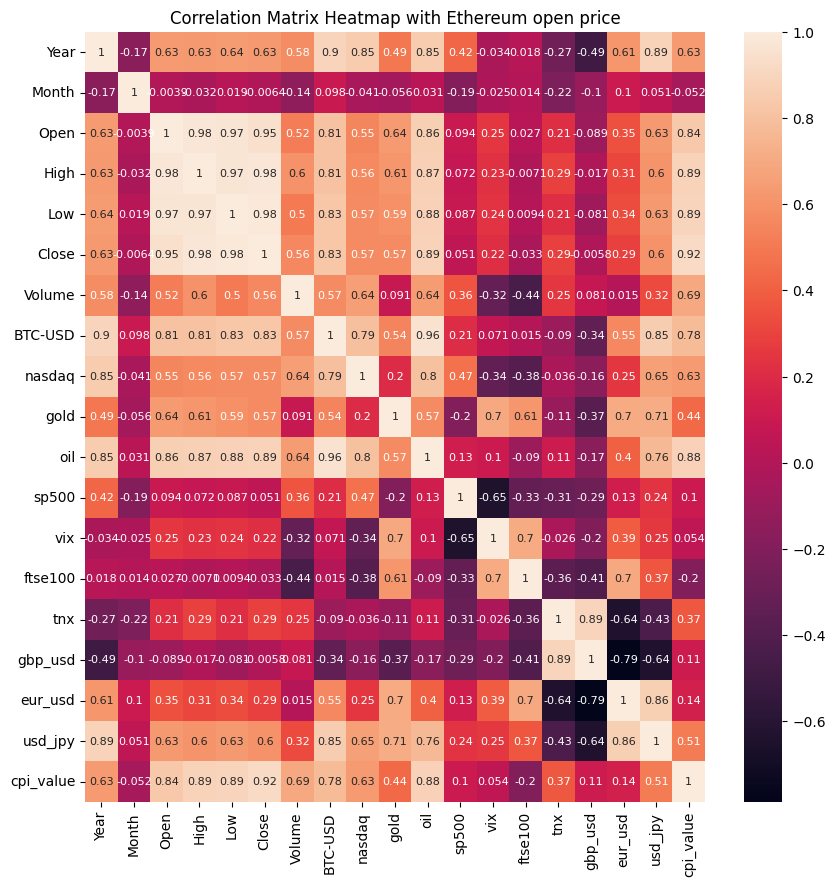

In [39]:
plt.figure(figsize=(10,10)) #to increase the size of the figure
sns.heatmap(corr_matrix, annot=True, annot_kws={'size': 8})
plt.title("Correlation Matrix Heatmap with Ethereum open price", loc="center")

In [40]:
monthly_df

,Year,Month,Open,High,Low,Close,Volume,BTC-USD,nasdaq,gold,oil,sp500,vix,ftse100,tnx,gbp_usd,eur_usd,usd_jpy,cpi_value,Year_Month
0,2017,11,-0.687482,-0.624182,-0.646047,-0.597965,-1.191978,-1.261655,-1.331959,-0.378666,-1.194068,-1.289677,0.469585,0.333770,0.616338,0.822966,-0.199250,-0.471607,-0.607577,2017-11-01
1,2017,12,-0.581047,-0.362679,-0.519326,-0.332844,-1.011984,-1.303314,-1.199494,-0.222204,-1.155083,-1.320173,1.117247,0.320902,0.651431,0.973177,-0.117028,-0.471607,-0.367735,2017-12-01
2,2018,1,-0.315642,0.037921,-0.173008,-0.023231,-0.731786,-1.215943,-1.068630,0.001093,-0.930133,-1.002513,0.840677,0.658694,1.713575,1.756349,-0.507228,-1.169077,-0.608341,2018-01-01
3,2018,2,-0.004887,-0.159516,-0.350172,-0.248529,-1.000170,-1.219369,-1.162676,-0.158997,-1.094847,-0.200741,0.299553,0.817402,1.342496,1.456292,-0.630230,-1.099292,-0.597531,2018-02-01
4,2018,3,-0.229961,-0.363873,-0.567721,-0.641342,-1.099462,-1.093879,-1.133462,0.011973,-1.204117,-0.185493,-0.014861,0.681213,1.525653,1.577701,-0.719422,-1.064338,-0.806899,2018-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2022,10,0.173581,0.197528,0.320976,0.365868,-0.000873,1.371123,0.119552,1.130527,0.639686,0.565454,0.053115,2.113879,-2.089114,-2.352612,3.173438,1.944205,0.019856,2022-10-01
60,2022,11,0.382498,0.204037,0.185512,0.128655,0.132040,1.802817,0.560168,0.820710,0.951397,-0.107984,0.911524,1.712819,-1.567850,-1.734071,2.319482,1.925518,-0.183570,2022-11-01
61,2022,12,0.145870,-0.025125,0.269280,0.043954,-0.740082,1.321829,0.855113,0.805685,0.591042,0.030515,0.693783,1.901553,-1.405241,-1.171179,1.770491,1.868771,-0.221543,2022-12-01
62,2023,1,0.061214,0.213377,0.303646,0.377702,-0.526550,1.241084,1.294528,0.733671,0.946141,-0.257920,1.267729,1.526229,-0.963639,-0.853216,1.540967,2.016101,0.181481,2023-01-01


In [41]:
# Assuming your DataFrame is called "df"
cpi_data_df = cpi_data_df.reset_index()

# This will make "date" a regular column in the DataFrame

In [42]:
cpi_data_df

,date,year,period,value,inflation_rate,cpi_value,cpi_Data_df
0,2018-01-01,2018,M01,247.867,NaN,247.867,247.867
1,2018-02-01,2018,M02,248.991,0.453469,248.991,248.991
2,2018-03-01,2018,M03,249.554,0.226113,249.554,249.554
3,2018-04-01,2018,M04,250.546,0.397509,250.546,250.546
4,2018-05-01,2018,M05,251.588,0.415892,251.588,251.588
...,...,...,...,...,...,...,...
57,2022-10-01,2022,M10,298.012,0.405649,298.012,298.012
58,2022-11-01,2022,M11,297.711,-0.101003,297.711,297.711
59,2022-12-01,2022,M12,296.797,-0.307009,296.797,296.797
60,2023-01-01,2023,M01,299.170,0.799536,299.170,299.170


In [43]:
cpi_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            62 non-null     datetime64[ns]
 1   year            62 non-null     int64         
 2   period          62 non-null     object        
 3   value           62 non-null     float64       
 4   inflation_rate  61 non-null     float64       
 5   cpi_value       62 non-null     float64       
 6   cpi_Data_df     62 non-null     float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 3.5+ KB


In [44]:
eth_usd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1910 entries, 2017-11-09 to 2023-01-31
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1910 non-null   float64
 1   High          1910 non-null   float64
 2   Low           1910 non-null   float64
 3   Close         1910 non-null   float64
 4   Volume        1910 non-null   int64  
 5   Dividends     1910 non-null   float64
 6   Stock Splits  1910 non-null   float64
 7   eth_usd       1910 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 198.8 KB


# 2.2 Features description

Close- Ethereum closing price in USD

Open- Ethereum opening price in USD

High- Ethereum highest price of the day in USD

Low- Ethereum lowest price of the day in USD

Volume- Ethereum total transactions volume of the day

Nasdak- National Association of Securities Dealers Automated Quotations closing price in USD

SP500- Standard and Poor's 500 closing price in USD. Index of 500 large listed limited liability companies traded in the United 
States

Gold- Gold closing price in USD

Oil- Oil closing price in USD

Vix- Volatility Index closing price in USD. Measure of stock market expectations of volatility based on S&P 500 index

Ftse100- Financial Times Stock Exchange 100 Index closing price in GBP. Share index of the 100 companies listed on the London 
Stock Exchange with the highest market capitalisation. 

Tnx- Treasury Yield 10 Years

Gbp_usd- British pound sterling closing price in USD

Eur_usd- Euro closing price in USD

Usd_jpy- US Dollar closing price in Japanese yen



2.3 Descriptive statistics

In [45]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [46]:
monthly_df.describe().transpose().rename(columns={'count': 'count', 'mean':'mean', 'std':'standard deviation', 'min':'minimum', '25%':'25% percentile', '50%':'median', '75%':'75% percentil', 'max':'maximum'})

,count,mean,standard deviation,minimum,25% percentile,median,75% percentil,maximum
Year,64.000,2020.000,1.574,2017.000,2019.000,2020.000,2021.000,2023.000
Month,64.000,6.500,3.599,1.000,3.000,6.500,10.000,12.000
Open,64.000,0.000,1.008,-0.870,-0.774,-0.520,0.406,2.990
High,64.000,-0.000,1.008,-0.895,-0.821,-0.472,0.435,2.553
Low,64.000,-0.000,1.008,-0.870,-0.770,-0.523,0.543,3.201
Close,64.000,0.000,1.008,-0.889,-0.793,-0.470,0.398,2.985
Volume,64.000,-0.000,1.008,-1.257,-0.846,-0.105,0.525,3.774
BTC-USD,64.000,0.000,1.008,-1.303,-0.953,-0.244,1.003,1.860
nasdaq,64.000,-0.000,1.008,-1.659,-1.149,0.370,0.829,1.447
gold,64.000,0.000,1.008,-2.376,-0.569,-0.050,0.537,2.588


Text(0.5, 1.0, 'Inflation in the USA by month Base year: 1982-84=100')

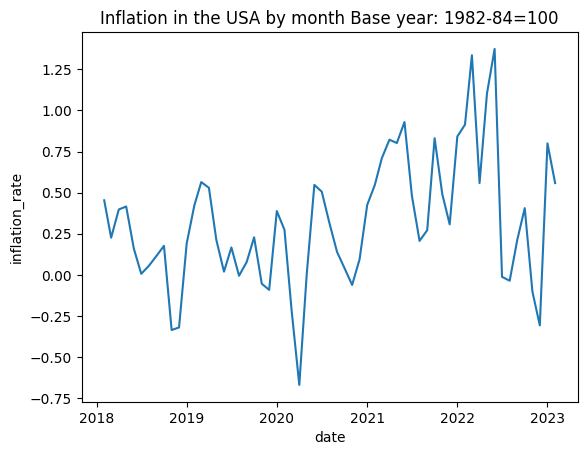

In [47]:
sns.lineplot(x="date", y="inflation_rate",
             data=cpi_data_df)
# Add title
plt.title("Inflation in the USA by month Base year: 1982-84=100")

Text(0.5, 1.0, 'Consumer Price Index in the USA, Base year: 1982-84=100')

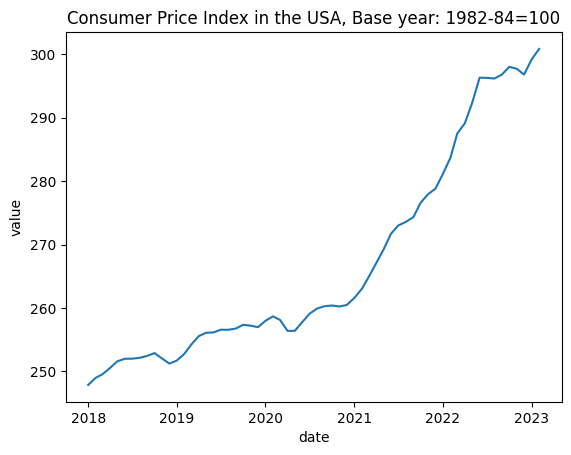

In [48]:
sns.lineplot(x="date", y="value",
             data=cpi_data_df)
# Add title
plt.title("Consumer Price Index in the USA, Base year: 1982-84=100")

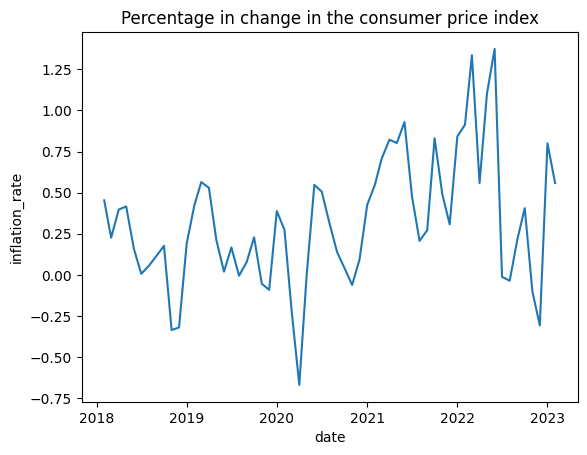

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate inflation rate as a percentage
cpi_data_df['inflation_rate'] = cpi_data_df['value'].pct_change() * 100

# Create line plot
sns.lineplot(x="date", y="inflation_rate", data=cpi_data_df)

# Add title
plt.title("Percentage in change in the consumer price index")

# Show plot
plt.show()


Build LSTM model

1. Prepare data for training and testing
2.

In [50]:
monthly_df_copy['Year_Month'] = pd.to_datetime(monthly_df_copy['Year_Month'], format='%Y-%m-%d')

y_overall = monthly_df_copy.loc[(monthly_df_copy['Year_Month'] >= '2017-11-10')
                     & (monthly_df_copy['Year_Month'] <= '2023-02-01')]


In [51]:
monthly_df_copy

,Year,Month,Open,High,Low,Close,Volume,BTC-USD,nasdaq,gold,oil,sp500,vix,ftse100,tnx,gbp_usd,eur_usd,usd_jpy,cpi_value,Year_Month
0,2017,11,320.671,522.307,294.542,447.114,26064246848.000,24.142,1273.200,57.400,2647.580,11.280,7326.700,2.417,1.342,1.185,112.002,259.101,10233.600,2017-11-01
1,2017,12,445.209,881.944,414.411,756.733,79862276544.000,23.545,1306.300,60.420,2673.610,11.040,7687.800,2.405,1.344,1.194,112.875,259.101,14156.400,2017-12-01
2,2018,1,755.757,1432.880,742.004,1118.310,163610220288.000,24.796,1339.000,64.730,2823.810,13.540,7533.600,2.720,1.416,1.241,108.732,247.867,10221.100,2018-01-01
3,2018,2,1119.370,1161.350,574.419,855.199,83393441152.000,24.747,1315.500,61.640,2713.830,19.850,7231.900,2.868,1.391,1.223,107.426,248.991,10397.900,2018-02-01
4,2018,3,856.012,880.302,368.633,396.457,53716179584.000,26.543,1322.800,64.940,2640.870,19.970,7056.600,2.741,1.403,1.230,106.479,249.554,6973.530,2018-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2022,10,1328.194,1652.382,1209.278,1572.714,382071643030.000,61.819,1635.900,86.530,3871.980,25.880,7094.500,4.077,1.160,0.996,147.812,298.012,20495.773,2022-10-01
60,2022,11,1572.645,1661.335,1081.138,1295.689,421797905717.000,67.997,1746.000,80.550,4080.110,20.580,7573.100,3.703,1.195,1.032,138.745,297.711,17168.566,2022-11-01
61,2022,12,1295.770,1346.174,1160.377,1196.771,161130639970.000,61.114,1819.700,80.260,3839.500,21.670,7451.700,3.879,1.206,1.066,132.916,296.797,16547.496,2022-12-01
62,2023,1,1196.714,1674.179,1192.885,1586.535,224952954314.000,59.958,1929.500,78.870,4076.600,19.400,7771.700,3.529,1.235,1.085,130.479,299.170,23139.283,2023-01-01


In [52]:
names = cycle(['Ethereum Open Price','Ethereum Close Price','Ethereum High Price','Ethereum Low Price'])

fig = px.line(y_overall, x=y_overall['Year_Month'], y=[y_overall['Open'], y_overall['Close'], 
                                          y_overall['High'], y_overall['Low']],
             labels={'Year_Month':'Year_Month','Close':'Ethereum close value'})
fig.update_layout(title_text='Ethereum analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [53]:
# Create a new table which only has the data and the close ethereum price
closedf = monthly_df_copy[['Year_Month','Close']]
print('Shae of close dataframe:', closedf.shape)

Shae of close dataframe: (64, 2)


In [54]:
closedf

,Year_Month,Close
0,2017-11-01,447.114
1,2017-12-01,756.733
2,2018-01-01,1118.310
3,2018-02-01,855.199
4,2018-03-01,396.457
...,...,...
59,2022-10-01,1572.714
60,2022-11-01,1295.689
61,2022-12-01,1196.771
62,2023-01-01,1586.535


Normalizing the data

In [55]:
# deleting date column and normalizing using MinMax Scaler

del closedf['Year_Month']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(64, 1)


In [56]:
# we keep the training set as 60% and 40% testing set

training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (38, 1)
test_data:  (26, 1)


In [57]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [58]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (22, 15)
y_train:  (22,)
X_test:  (10, 15)
y_test (10,)


In [59]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (22, 15, 1)
X_test:  (10, 15, 1)


In [60]:
from tensorflow.keras.layers import Dropout
#Initialising the LSTM
model_simple_lSTM = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model_simple_lSTM.add(LSTM(units = 6, activation='sigmoid', input_shape = (X_train.shape[1], X_train.shape[2])))
model_simple_lSTM.add(Dropout(0.7))

#Adding the output layer
model_simple_lSTM.add(Dense(units = 1))

# Compiling the RNN
model_simple_lSTM.compile(optimizer = 'Adam', metrics=["mae"], loss = 'mean_squared_error')

In [61]:
tf.keras.utils.plot_model(
    model_simple_lSTM,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [62]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


#early_stop and ModelCheckpoint
# the model stops learning when 
callbacks  = [keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 30, mode='min', min_delta=0),
              keras.callbacks.ModelCheckpoint("model_simple_lSTM.keras", monitor='val_loss', save_best_only=True, mode='min')]

In [63]:
history_simple_lSTM = model_simple_lSTM.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test), batch_size=32, 
                             callbacks = [callbacks])

Epoch 1/300
1/1 [==============================] - 1s 1s/step - loss: 0.1979 - mae: 0.3514 - val_loss: 0.0910 - val_mae: 0.2792
Epoch 2/300
1/1 [==============================] - 0s 25ms/step - loss: 0.2905 - mae: 0.4378 - val_loss: 0.0922 - val_mae: 0.2814
Epoch 3/300
1/1 [==============================] - 0s 25ms/step - loss: 0.2178 - mae: 0.4050 - val_loss: 0.0930 - val_mae: 0.2828
Epoch 4/300
1/1 [==============================] - 0s 24ms/step - loss: 0.3909 - mae: 0.4909 - val_loss: 0.0939 - val_mae: 0.2845
Epoch 5/300
1/1 [==============================] - 0s 24ms/step - loss: 0.1320 - mae: 0.3152 - val_loss: 0.0945 - val_mae: 0.2855
Epoch 6/300
1/1 [==============================] - 0s 27ms/step - loss: 0.2253 - mae: 0.3964 - val_loss: 0.0953 - val_mae: 0.2869
Epoch 7/300
1/1 [==============================] - 0s 27ms/step - loss: 0.3667 - mae: 0.5066 - val_loss: 0.0956 - val_mae: 0.2875
Epoch 8/300
1/1 [==============================] - 0s 30ms/step - loss: 0.2657 - mae: 0.3920

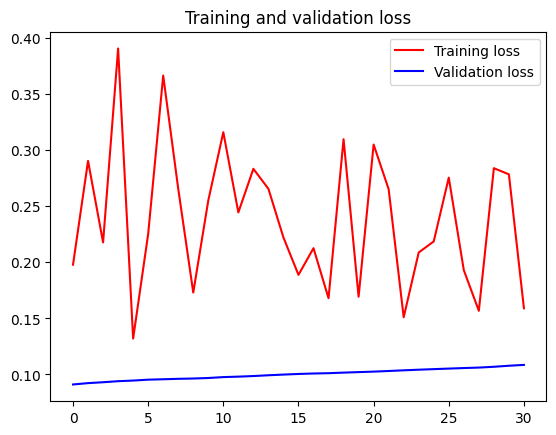

<Figure size 640x480 with 0 Axes>

In [64]:
import matplotlib.pyplot as plt

loss = history_simple_lSTM.history['loss']
val_loss = history_simple_lSTM.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [65]:
### Lets Do the prediction and check performance metrics
train_predict=model_simple_lSTM.predict(X_train)
test_predict=model_simple_lSTM.predict(X_test)
train_predict.shape, test_predict.shape

1/1 [==============================] - 0s 15ms/step


((22, 1), (10, 1))

In [66]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [67]:
# Evaluation metrices RMSE and MAE
from sklearn.metrics import mean_absolute_error
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  201.9106286851993
Train data MSE:  40767.90197605243
Train data MAE:  183.41051621870562
-------------------------------------------------------------------------------------
Test data RMSE:  1490.1740394821866
Test data MSE:  2220618.6679466576
Test data MAE:  1399.6776193618775


In [68]:
from sklearn.metrics import explained_variance_score
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: -0.14826123436179306
Test data explained variance regression score: -0.2965939186801507


In [69]:
from sklearn.metrics import r2_score
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: -1.9584314565805023
Test data R2 score: -10.009586727332831


In [70]:
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_poisson_deviance
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.4105028329826702
Test data MGD:  40.662493814461534
----------------------------------------------------------------------
Train data MPD:  126.1022222140372
Test data MPD:  5318.173776185145


In [71]:
monthly_df_copy

,Year,Month,Open,High,Low,Close,Volume,BTC-USD,nasdaq,gold,oil,sp500,vix,ftse100,tnx,gbp_usd,eur_usd,usd_jpy,cpi_value,Year_Month
0,2017,11,320.671,522.307,294.542,447.114,26064246848.000,24.142,1273.200,57.400,2647.580,11.280,7326.700,2.417,1.342,1.185,112.002,259.101,10233.600,2017-11-01
1,2017,12,445.209,881.944,414.411,756.733,79862276544.000,23.545,1306.300,60.420,2673.610,11.040,7687.800,2.405,1.344,1.194,112.875,259.101,14156.400,2017-12-01
2,2018,1,755.757,1432.880,742.004,1118.310,163610220288.000,24.796,1339.000,64.730,2823.810,13.540,7533.600,2.720,1.416,1.241,108.732,247.867,10221.100,2018-01-01
3,2018,2,1119.370,1161.350,574.419,855.199,83393441152.000,24.747,1315.500,61.640,2713.830,19.850,7231.900,2.868,1.391,1.223,107.426,248.991,10397.900,2018-02-01
4,2018,3,856.012,880.302,368.633,396.457,53716179584.000,26.543,1322.800,64.940,2640.870,19.970,7056.600,2.741,1.403,1.230,106.479,249.554,6973.530,2018-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2022,10,1328.194,1652.382,1209.278,1572.714,382071643030.000,61.819,1635.900,86.530,3871.980,25.880,7094.500,4.077,1.160,0.996,147.812,298.012,20495.773,2022-10-01
60,2022,11,1572.645,1661.335,1081.138,1295.689,421797905717.000,67.997,1746.000,80.550,4080.110,20.580,7573.100,3.703,1.195,1.032,138.745,297.711,17168.566,2022-11-01
61,2022,12,1295.770,1346.174,1160.377,1196.771,161130639970.000,61.114,1819.700,80.260,3839.500,21.670,7451.700,3.879,1.206,1.066,132.916,296.797,16547.496,2022-12-01
62,2023,1,1196.714,1674.179,1192.885,1586.535,224952954314.000,59.958,1929.500,78.870,4076.600,19.400,7771.700,3.529,1.235,1.085,130.479,299.170,23139.283,2023-01-01


In [72]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'Year_Month': monthly_df_copy['Year_Month'],
                       'original_close': monthly_df_copy['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['Year_Month'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Ethereum price ($)','Year_Month': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (64, 1)
Test predicted data:  (64, 1)


In [73]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model_simple_lSTM.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_simple_lSTM.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [74]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [75]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Ethereum price ($)','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


In [76]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Ethereum price ($)','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing Ethereum price ($) with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()